In [1]:
import pandas as pd
import numpy as np
import math

import librosa as lb # https://librosa.github.io/librosa/
import soundfile as sf # https://pysoundfile.readthedocs.io/en/latest/

import os

import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats

I had to look first where the audio and text files are by using !ls

In [2]:
#!ls ../input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database

audio_and_txt_files	  filename_format.txt
filename_differences.txt  patient_diagnosis.csv


Load the patient diagnosis file first and check all the unique diagnosis we have in our data.

首先加载患者诊断文件，并检查我们数据中所有独特的诊断。

This is necessary in how we will sort our output later.

这对于我们以后如何对输出进行排序是必要的。

In [5]:
#load patient diagnosis.csv
#
diag_csv = './archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosis = pd.read_csv(diag_csv, names=['pId', 'diagnosis'])
diagnosis

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [7]:
ds = diagnosis['diagnosis'].unique()
ds

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

Next we will need to read all the unique files in our dataset. This is done by using the os.listdir function with the condition of checking only .txt files.

Note: We can also use the condition to check .wav files. Eitherway we'll just check all unique files. Condition is needed because if we're checking all kinds of files, we may get replicates. Our dataset consists of .txt and its equivalent .wav files.

In [8]:
#get all text files
audio_text_loc = './archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
files = [s.split('.')[0] for s in os.listdir(path = audio_text_loc) if '.txt' in s]
files

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200',
 '104_1b1_Ar_sc_Litt3200',
 '104_1b1_Ll_sc_Litt3200',
 '104_1b1_Lr_sc_Litt3200',
 '104_1b1_Pl_sc_Litt3200',
 '104_1b1_Pr_sc_Litt3200',
 '105_1b1_Tc_sc_Meditron',
 '106_2b1_Pl_mc_LittC2SE',
 '106_2b1_Pr_mc_LittC2SE',
 '107_2b3_Al_mc_AKGC417L',
 '107_2b3_Ar_mc_AKGC417L',
 '107_2b3_Ll_mc_AKGC417L',
 '107_2b3_Lr_mc_AKGC417L',
 '107_2b3_Pl_mc_AKGC417L',
 '107_2b3_Pr_mc_AKGC417L',
 '107_2b3_Tc_mc_AKGC417L',
 '107_2b4_Al_mc_AKGC417L',
 '107_2b4_Ar_mc_AKGC417L',
 '107_2b4_Ll_mc_AKGC417L',
 '107_2b4_Lr_mc_AKGC417L',
 '107_2b4_Pl_mc_AKGC417L',
 '107_2b4_Pr_mc_AKGC417L',
 '107_2b4_Tc_mc_AKGC417L',
 '107_2b5_Al_mc_AKGC417L',
 '107_2b5_Ar_mc_AKGC417L',
 '107_2b5_Ll_mc_AKGC417L',
 '107_2b5_Lr_mc_AKGC417L',
 '107_2b5_Pl_mc_AKGC417L',
 '107_2b5_Pr_mc_AKGC417L',
 '107_2b5_Tc_mc_AKGC417L',
 '107_3p2_Al_mc_AKGC417L',
 '107_3p2_Ar_mc_AKGC417L',
 '107_3p2_Ll_mc_AKGC417L',
 

We know that our filenames have a certain meaning in them. We get all info (or tokens) by splitting the filename by using "_" as separators. We define a function to do this task.

我们知道我们的文件名在其中有一定的含义。我们通过使用“_”作为分隔符分割文件名来获得所有信息(或标记)。我们定义一个函数来完成这项任务。

In [9]:
def tokenize_file(filename):
    return filename.split('_')

Now that we have our files list, we have to read each one to get the crackles and wheezes information--including when in the audio file it is recorded (start and end time denoted in seconds).

现在我们有了文件列表，我们必须阅读每个文件以获得噼啪声和喘息信息——包括在音频文件中记录它的时间(开始和结束时间以秒表示)。

I've created the files_df to compile all these data (which includes the patient id and acquisition mode--stereo or mono--which will be used later).

我已经创建了files_df来编译所有这些数据(其中包括患者id和获取模式——立体声或单声道——稍后将使用)。

In [14]:
#read each file

files_ = []
for f in files:
    df = pd.read_csv(audio_text_loc + '/' + f + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    df['filename'] = f
    #get filename features
    f_features = tokenize_file(f)
    df['pId'] = f_features[0]
    df['ac_mode'] = f_features[3]
    
    files_.append(df)
    
files_df = pd.concat(files_)
files_df.reset_index() # 使用索引重置生成一个新的DataFrame或Series
files_df

,start,end,crackles,wheezes,filename,pId,ac_mode
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,101,sc
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,101,sc
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,101,sc
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,101,sc
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,101,sc
...,...,...,...,...,...,...,...
6,11.721,13.693,1,0,226_1b1_Pl_sc_LittC2SE,226,sc
7,13.693,15.536,0,0,226_1b1_Pl_sc_LittC2SE,226,sc
8,15.536,17.493,0,0,226_1b1_Pl_sc_LittC2SE,226,sc
9,17.493,19.436,1,0,226_1b1_Pl_sc_LittC2SE,226,sc


We want to combine the 2 dataframes we've made so far. However to do that, we have to make sure that the column where we'll combine them must have the same data type.

然而，要做到这一点，我们必须确保将它们组合在一起的列必须具有相同的数据类型。

In this case I just changed the files_df pId column to float64 to be the same as the diagnosis pId dataframe. We can also use int32 to minimise the data allocation in our system however that'll not be our concern for now.

在本例中，我只是将files_df pId列更改为float64，以便与诊断pId相同。

Once the 2 columns have the same data type, we'll use the pandas merge function to combine the 2 dataframes.

一旦两列具有相同的数据类型，我们将使用 pandas merge 函数来组合两个数据。

In [15]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   filename  6898 non-null   object 
 5   pId       6898 non-null   object 
 6   ac_mode   6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [18]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pId        126 non-null    int64 
 1   diagnosis  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [19]:
files_df['pId'] = files_df['pId'].astype('float64')
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   filename  6898 non-null   object 
 5   pId       6898 non-null   float64
 6   ac_mode   6898 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 431.1+ KB


In [20]:
files_df = pd.merge(files_df, diagnosis, on='pId')
files_df

,start,end,crackles,wheezes,filename,pId,ac_mode,diagnosis
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
...,...,...,...,...,...,...,...,...
6893,11.721,13.693,1,0,226_1b1_Pl_sc_LittC2SE,226.0,sc,Pneumonia
6894,13.693,15.536,0,0,226_1b1_Pl_sc_LittC2SE,226.0,sc,Pneumonia
6895,15.536,17.493,0,0,226_1b1_Pl_sc_LittC2SE,226.0,sc,Pneumonia
6896,17.493,19.436,1,0,226_1b1_Pl_sc_LittC2SE,226.0,sc,Pneumonia


We want to slice the wav file into subslices to get the pure breathing part of the audio file. Again, this is denoted by the start and end times mentioned in the txt files. 

我们要切割 wav 文件成子片，以获得纯呼吸部分的音频文件。同样，这是由 txt 文件中提到的开始和结束时间表示的。

I've defined the slice_data function to do this.

In [37]:
#code taken from eatmygoose https://www.kaggle.com/eatmygoose/cnn-detection-of-wheezes-and-crackles
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

So.. sure we can slice the audio files, but there are things we need to consider as well
- We need to make sure that they will have the same length (this is in preparation for feeding them into the model for training later)

我们需要确保它们具有相同的长度(这是为以后将它们输入模型进行训练做准备)

- If they're not the same length, then we have to pad the audio with silent (or zeroes) sounds.

如果它们的长度不一样，那么我们必须用静音(或零)声音来填充音频

- For the length, we have to know what is the optimal length of time we should use.

对于长度，我们必须知道我们应该使用的最佳时间长度。

For the next part I tried to get the max length per slice that we currently have in our dataframe

下一部分，我尝试得到每个切片的最大长度，我们目前在我们的数据模型

In [21]:
files_df['len_per_slice'] = files_df['end'].sub(files_df['start'], axis = 0) #sub 减法功能
max_len_per_slice = max(files_df['len_per_slice'])
max_len_per_slice

16.163

16 seconds long? Is there someone who can have breathe as long as 16 seconds? No, obviously.

16秒? 有人能呼吸到16秒吗?-当然没有。

So we try and understand our data and check the outliers and the relative maximum of the dataset.

所以我们尝试理解我们的数据，检查异常值和数据集的相对最大值。

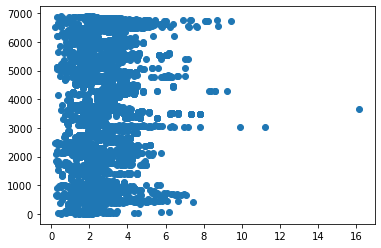

In [23]:
plt.scatter(files_df['len_per_slice'], y=files_df.index)

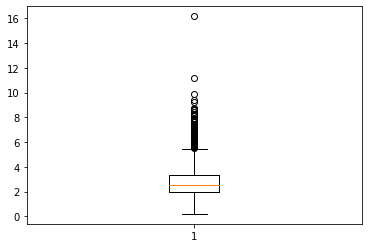

In [25]:
box = plt.boxplot(files_df['len_per_slice'])

And define the forced maximum length force_max_len as round up of the relative max (5.48 sec round up to 6 sec) length of time.

定义强制最大长度 force_max_len 作为相对最大值的总和

In [29]:
boxplot_stats(files_df['len_per_slice'])

[{'mean': 2.7005090852420994,
  'iqr': 1.4370000000000003,
  'cilo': 2.509835930964254,
  'cihi': 2.564164069035744,
  'whishi': 5.479999999999997,
  'whislo': 0.20000000000000284,
  'fliers': array([ 5.759  ,  6.1938 ,  7.444  ,  6.082  ,  5.642  ,  5.58302,
          6.663  ,  5.802  ,  5.954  ,  5.942  ,  5.94   ,  5.753  ,
          7.057  ,  6.829  ,  6.514  ,  6.615  ,  6.4034 ,  5.583  ,
          6.9793 ,  6.303  ,  6.5858 ,  6.0792 ,  5.566  ,  5.932  ,
          5.557  ,  5.686  ,  5.742  ,  7.1556 ,  6.222  ,  6.442  ,
          7.7853 ,  6.946  ,  9.915  , 11.205  ,  5.8416 ,  6.33   ,
          5.638  ,  5.608  ,  5.576  ,  5.576  ,  5.576  ,  5.576  ,
          5.576  ,  5.576  ,  7.312  ,  7.83   ,  7.312  ,  7.83   ,
          7.312  ,  7.83   ,  7.312  ,  7.83   ,  7.312  ,  7.83   ,
          7.312  ,  7.83   ,  7.312  ,  7.83   ,  6.211  ,  6.644  ,
          6.211  ,  6.644  ,  6.211  ,  6.644  ,  6.211  ,  6.644  ,
          6.211  ,  6.644  ,  6.677  ,  6.344  ,  

In [30]:
force_max_len = math.ceil(boxplot_stats(files_df['len_per_slice'])[0]['whishi']) # Math.ceil() 函数返回大于或等于一个给定数字的最小整数
force_max_len

6

Next is we have to compute the length of the raw data of the slices. I defined a function compute_len to do this.

接下来我们要计算切片的原始数据的长度。我定义了一个函数计算 len 来做这个

Remember we had to store the acquisition mode? It's because it has different computation for stereo and mono.

还记得我们存储的采集模式吗? 因为它有不同的计算立体声和单声道。

- Stereo（立体声）: (Sampling rate * time) * 2
- Mono（单声道）: (Sampling rate * time)

In [32]:
def compute_len(samp_rate=22050, time=force_max_len, acquisition_mode=0):
    '''Computes the supposed length of sliced data
        计算假设的分片数据长度
        samp_size = sample size from the data
        samp_rate = sampling rate. by default since we're working on 24-bit files, we'll use 96kHz 默认情况下，因为我们正在工作的24位文件，我们将使用96khz
        time = length of time for the audio file. by default we'll use the max we have which is 5.48
        acquisition_mode = either mono or stereo. 0 for mono, 1 for stereo 单声道或立体声。0是单声道，1是立体声
    '''
    comp_len = 0
    if acquisition_mode == 1: #ac mode is single channel which means it's 'mono'
        comp_len = samp_rate * time
    else: #stereo
        comp_len = (samp_rate * time) * 2

    return comp_len

We're almost ready to create new wav files based on the slices. There's one more problem: we must prepare where to store these new wav files.

我们几乎可以基于切片创建新的 wav 文件了。还有一个问题: 我们必须准备把这些新的 wav 文件存放在哪里。

So we have to create our output directory and subfolders as defined by the unique diagnosis.

因此，我们必须创建我们的输出目录和子文件夹定义的唯一诊断。

In [33]:
#create output path
os.makedirs('output')

In [34]:
for d in ds:
    path = os.path.join('output', d)
    os.makedirs(path)

Which we can now check using !ls

In [35]:
!ls

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


Alright time to roll! Now that everything is set, let's start processing the files now. 

好了，开始吧! 现在一切都准备好了，我们开始处理文件吧。

The first thing you might notice is the declaration of the i = 0. This will be used in saving of files later. As you may know, each wav file will consist of different slices. When saving these slices, we'll add the ith number of slice. For example, 104_1b1_Ll_sc_Litt3200.wav might have 4 slices, so we'll save them as 

你可能注意到的第一件事是 i = 0的声明。这个稍后将用于保存文件。你可能知道，每个 wav 文件都由不同的片组成。保存这些切片的时候，我们要加上切片的数量。例如，104_1b1_Ll_sc_Litt3200.wav 可能有4个切片，所以我们将它们保存为

- 104_1b1_Ll_sc_Litt3200_0, 
- 104_1b1_Ll_sc_Litt3200_1, 
- 104_1b1_Ll_sc_Litt3200_2, 
- 104_1b1_Ll_sc_Litt3200_3

Next, for each file 
- get the filename (which will be used for saving later)
- get the start and end times for the processing of the sliced wav files

获取分片WAV文件处理的开始时间和结束时间

- get the diagnosis so we'll know which subfolder we'll save the sliced wav file

获得诊断，这样我们就知道将保存切片WAV文件的子文件夹

If the slice is greater than force_max_len(6s), force the slice to only be force_max_len long.

如果切片大于force_max_len，则强制切片长度仅为force_max_len

Using the librosa function load, load the wav file which returns raw data and the sampling rate.

使用librosa函数load，加载返回原始数据和采样率的wav文件。

Then we feed the raw data to the compute_len function we defined earlier to get the expected length of data.

然后，我们将原始数据提供给前面定义的COMPUTE_LEN函数，以获得预期的数据长度

Pad the sliced audio with zeroes using the librosa function util.pad_center.

使用librosa函数util.pad_center用零填充切片的音频

Then finally, save this file to our destination path which includes which subfolder we'll save it.

最后，将该文件保存到我们的目标路径，其中包括要保存它的子文件夹。

TLDR;
- Read the audio file
- Slice the audio file
- Pad in case it's less than 6 sec
- Save

In [38]:
i = 0 #iterator for file naming

for idx, row in files_df.iterrows():
    filename = row['filename']
    start = row['start']
    end = row['end']
    diag = row['diagnosis']
    
    #check len and force to 6 sec if more than that
    if force_max_len < end - start:
        end = start + force_max_len
    
    aud_loc = audio_text_loc + '/' + f + '.wav'
    
    if idx != 0:
        if files_df.iloc[idx-1]['filename'] == filename:
            i=i+1
        else:
            i=0
    n_filename = filename + '_' + str(i) + '.wav'
    path = 'output/' + diag + '/' + n_filename
    
    print('processing ' + n_filename + '...')

    data, samplingrate = lb.load(aud_loc)
    sliced_data = slice_data(start=start, end=end, raw_data=data, sample_rate=samplingrate)
    
    #pad audio if < forced_max_len
    a_len = compute_len(samp_rate=samplingrate, acquisition_mode=row['ac_mode']=='sc')
    padded_data = lb.util.pad_center(sliced_data, a_len)

    sf.write(file=path, data=padded_data, samplerate=samplingrate)


processing 101_1b1_Al_sc_Meditron_0.wav...
processing 101_1b1_Al_sc_Meditron_1.wav...
processing 101_1b1_Al_sc_Meditron_2.wav...
processing 101_1b1_Al_sc_Meditron_3.wav...
processing 101_1b1_Al_sc_Meditron_4.wav...
processing 101_1b1_Al_sc_Meditron_5.wav...
processing 101_1b1_Al_sc_Meditron_6.wav...
processing 101_1b1_Al_sc_Meditron_7.wav...
processing 101_1b1_Al_sc_Meditron_8.wav...
processing 101_1b1_Al_sc_Meditron_9.wav...
processing 101_1b1_Al_sc_Meditron_10.wav...
processing 101_1b1_Al_sc_Meditron_11.wav...
processing 101_1b1_Pr_sc_Meditron_0.wav...
processing 101_1b1_Pr_sc_Meditron_1.wav...
processing 101_1b1_Pr_sc_Meditron_2.wav...
processing 101_1b1_Pr_sc_Meditron_3.wav...
processing 101_1b1_Pr_sc_Meditron_4.wav...
processing 101_1b1_Pr_sc_Meditron_5.wav...
processing 101_1b1_Pr_sc_Meditron_6.wav...
processing 101_1b1_Pr_sc_Meditron_7.wav...
processing 101_1b1_Pr_sc_Meditron_8.wav...
processing 101_1b1_Pr_sc_Meditron_9.wav...
processing 101_1b1_Pr_sc_Meditron_10.wav...
processi

processing 107_2b4_Ar_mc_AKGC417L_4.wav...
processing 107_2b4_Ar_mc_AKGC417L_5.wav...
processing 107_2b4_Ar_mc_AKGC417L_6.wav...
processing 107_2b4_Ar_mc_AKGC417L_7.wav...
processing 107_2b4_Ll_mc_AKGC417L_0.wav...
processing 107_2b4_Ll_mc_AKGC417L_1.wav...
processing 107_2b4_Ll_mc_AKGC417L_2.wav...
processing 107_2b4_Ll_mc_AKGC417L_3.wav...
processing 107_2b4_Ll_mc_AKGC417L_4.wav...
processing 107_2b4_Ll_mc_AKGC417L_5.wav...
processing 107_2b4_Ll_mc_AKGC417L_6.wav...
processing 107_2b4_Ll_mc_AKGC417L_7.wav...
processing 107_2b4_Lr_mc_AKGC417L_0.wav...
processing 107_2b4_Lr_mc_AKGC417L_1.wav...
processing 107_2b4_Lr_mc_AKGC417L_2.wav...
processing 107_2b4_Lr_mc_AKGC417L_3.wav...
processing 107_2b4_Lr_mc_AKGC417L_4.wav...
processing 107_2b4_Lr_mc_AKGC417L_5.wav...
processing 107_2b4_Lr_mc_AKGC417L_6.wav...
processing 107_2b4_Lr_mc_AKGC417L_7.wav...
processing 107_2b4_Pl_mc_AKGC417L_0.wav...
processing 107_2b4_Pl_mc_AKGC417L_1.wav...
processing 107_2b4_Pl_mc_AKGC417L_2.wav...
processing 

processing 109_1b1_Ll_sc_Litt3200_1.wav...
processing 109_1b1_Ll_sc_Litt3200_2.wav...
processing 109_1b1_Ll_sc_Litt3200_3.wav...
processing 109_1b1_Ll_sc_Litt3200_4.wav...
processing 109_1b1_Ll_sc_Litt3200_5.wav...
processing 109_1b1_Ll_sc_Litt3200_6.wav...
processing 109_1b1_Ll_sc_Litt3200_7.wav...
processing 109_1b1_Lr_sc_Litt3200_0.wav...
processing 109_1b1_Lr_sc_Litt3200_1.wav...
processing 109_1b1_Lr_sc_Litt3200_2.wav...
processing 109_1b1_Lr_sc_Litt3200_3.wav...
processing 109_1b1_Lr_sc_Litt3200_4.wav...
processing 109_1b1_Lr_sc_Litt3200_5.wav...
processing 109_1b1_Lr_sc_Litt3200_6.wav...
processing 109_1b1_Lr_sc_Litt3200_7.wav...
processing 109_1b1_Pl_sc_Litt3200_0.wav...
processing 109_1b1_Pl_sc_Litt3200_1.wav...
processing 109_1b1_Pl_sc_Litt3200_2.wav...
processing 109_1b1_Pl_sc_Litt3200_3.wav...
processing 109_1b1_Pl_sc_Litt3200_4.wav...
processing 109_1b1_Pl_sc_Litt3200_5.wav...
processing 109_1b1_Pl_sc_Litt3200_6.wav...
processing 109_1b1_Pl_sc_Litt3200_7.wav...
processing 

processing 113_1b1_Ll_sc_Litt3200_8.wav...
processing 113_1b1_Ll_sc_Litt3200_9.wav...
processing 113_1b1_Ll_sc_Litt3200_10.wav...
processing 113_1b1_Lr_sc_Litt3200_0.wav...
processing 113_1b1_Lr_sc_Litt3200_1.wav...
processing 113_1b1_Lr_sc_Litt3200_2.wav...
processing 113_1b1_Lr_sc_Litt3200_3.wav...
processing 113_1b1_Lr_sc_Litt3200_4.wav...
processing 113_1b1_Lr_sc_Litt3200_5.wav...
processing 113_1b1_Lr_sc_Litt3200_6.wav...
processing 113_1b1_Pl_sc_Litt3200_0.wav...
processing 113_1b1_Pl_sc_Litt3200_1.wav...
processing 113_1b1_Pl_sc_Litt3200_2.wav...
processing 113_1b1_Pl_sc_Litt3200_3.wav...
processing 113_1b1_Pl_sc_Litt3200_4.wav...
processing 113_1b1_Pl_sc_Litt3200_5.wav...
processing 113_1b1_Pl_sc_Litt3200_6.wav...
processing 113_1b1_Pl_sc_Litt3200_7.wav...
processing 113_1b1_Pr_sc_Litt3200_0.wav...
processing 113_1b1_Pr_sc_Litt3200_1.wav...
processing 113_1b1_Pr_sc_Litt3200_2.wav...
processing 113_1b1_Pr_sc_Litt3200_3.wav...
processing 113_1b1_Pr_sc_Litt3200_4.wav...
processing

processing 120_1b1_Ar_sc_Meditron_16.wav...
processing 120_1b1_Ar_sc_Meditron_17.wav...
processing 120_1b1_Ar_sc_Meditron_18.wav...
processing 120_1b1_Ar_sc_Meditron_19.wav...
processing 120_1b1_Lr_sc_Meditron_0.wav...
processing 120_1b1_Lr_sc_Meditron_1.wav...
processing 120_1b1_Lr_sc_Meditron_2.wav...
processing 120_1b1_Lr_sc_Meditron_3.wav...
processing 120_1b1_Lr_sc_Meditron_4.wav...
processing 120_1b1_Lr_sc_Meditron_5.wav...
processing 120_1b1_Lr_sc_Meditron_6.wav...
processing 120_1b1_Lr_sc_Meditron_7.wav...
processing 120_1b1_Lr_sc_Meditron_8.wav...
processing 120_1b1_Lr_sc_Meditron_9.wav...
processing 120_1b1_Lr_sc_Meditron_10.wav...
processing 120_1b1_Lr_sc_Meditron_11.wav...
processing 120_1b1_Lr_sc_Meditron_12.wav...
processing 120_1b1_Lr_sc_Meditron_13.wav...
processing 120_1b1_Lr_sc_Meditron_14.wav...
processing 120_1b1_Lr_sc_Meditron_15.wav...
processing 120_1b1_Lr_sc_Meditron_16.wav...
processing 120_1b1_Lr_sc_Meditron_17.wav...
processing 120_1b1_Lr_sc_Meditron_18.wav..

processing 124_1b1_Lr_sc_Litt3200_3.wav...
processing 124_1b1_Lr_sc_Litt3200_4.wav...
processing 124_1b1_Lr_sc_Litt3200_5.wav...
processing 124_1b1_Lr_sc_Litt3200_6.wav...
processing 124_1b1_Lr_sc_Litt3200_7.wav...
processing 124_1b1_Lr_sc_Litt3200_8.wav...
processing 124_1b1_Lr_sc_Litt3200_9.wav...
processing 124_1b1_Pl_sc_Litt3200_0.wav...
processing 124_1b1_Pl_sc_Litt3200_1.wav...
processing 124_1b1_Pl_sc_Litt3200_2.wav...
processing 124_1b1_Pl_sc_Litt3200_3.wav...
processing 124_1b1_Pl_sc_Litt3200_4.wav...
processing 124_1b1_Pl_sc_Litt3200_5.wav...
processing 124_1b1_Pl_sc_Litt3200_6.wav...
processing 124_1b1_Pr_sc_Litt3200_0.wav...
processing 124_1b1_Pr_sc_Litt3200_1.wav...
processing 124_1b1_Pr_sc_Litt3200_2.wav...
processing 124_1b1_Pr_sc_Litt3200_3.wav...
processing 124_1b1_Pr_sc_Litt3200_4.wav...
processing 124_1b1_Pr_sc_Litt3200_5.wav...
processing 125_1b1_Tc_sc_Meditron_0.wav...
processing 125_1b1_Tc_sc_Meditron_1.wav...
processing 125_1b1_Tc_sc_Meditron_2.wav...
processing 

processing 130_1p4_Pr_mc_AKGC417L_4.wav...
processing 130_1p4_Pr_mc_AKGC417L_5.wav...
processing 130_1p4_Pr_mc_AKGC417L_6.wav...
processing 130_1p4_Tc_mc_AKGC417L_0.wav...
processing 130_1p4_Tc_mc_AKGC417L_1.wav...
processing 130_1p4_Tc_mc_AKGC417L_2.wav...
processing 130_1p4_Tc_mc_AKGC417L_3.wav...
processing 130_1p4_Tc_mc_AKGC417L_4.wav...
processing 130_1p4_Tc_mc_AKGC417L_5.wav...
processing 130_1p4_Tc_mc_AKGC417L_6.wav...
processing 130_1p4_Tc_mc_AKGC417L_7.wav...
processing 130_2b2_Al_mc_AKGC417L_0.wav...
processing 130_2b2_Al_mc_AKGC417L_1.wav...
processing 130_2b2_Al_mc_AKGC417L_2.wav...
processing 130_2b2_Al_mc_AKGC417L_3.wav...
processing 130_2b2_Al_mc_AKGC417L_4.wav...
processing 130_2b2_Al_mc_AKGC417L_5.wav...
processing 130_2b2_Al_mc_AKGC417L_6.wav...
processing 130_2b2_Al_mc_AKGC417L_7.wav...
processing 130_2b2_Ar_mc_AKGC417L_0.wav...
processing 130_2b2_Ar_mc_AKGC417L_1.wav...
processing 130_2b2_Ar_mc_AKGC417L_2.wav...
processing 130_2b2_Ar_mc_AKGC417L_3.wav...
processing 

processing 130_2p5_Al_mc_AKGC417L_6.wav...
processing 130_2p5_Al_mc_AKGC417L_7.wav...
processing 130_2p5_Al_mc_AKGC417L_8.wav...
processing 130_2p5_Al_mc_AKGC417L_9.wav...
processing 130_2p5_Al_mc_AKGC417L_10.wav...
processing 130_2p5_Ar_mc_AKGC417L_0.wav...
processing 130_2p5_Ar_mc_AKGC417L_1.wav...
processing 130_2p5_Ar_mc_AKGC417L_2.wav...
processing 130_2p5_Ar_mc_AKGC417L_3.wav...
processing 130_2p5_Ar_mc_AKGC417L_4.wav...
processing 130_2p5_Ar_mc_AKGC417L_5.wav...
processing 130_2p5_Ar_mc_AKGC417L_6.wav...
processing 130_2p5_Ar_mc_AKGC417L_7.wav...
processing 130_2p5_Ar_mc_AKGC417L_8.wav...
processing 130_2p5_Ar_mc_AKGC417L_9.wav...
processing 130_2p5_Ar_mc_AKGC417L_10.wav...
processing 130_2p5_Lr_mc_AKGC417L_0.wav...
processing 130_2p5_Lr_mc_AKGC417L_1.wav...
processing 130_2p5_Lr_mc_AKGC417L_2.wav...
processing 130_2p5_Lr_mc_AKGC417L_3.wav...
processing 130_2p5_Lr_mc_AKGC417L_4.wav...
processing 130_2p5_Lr_mc_AKGC417L_5.wav...
processing 130_2p5_Lr_mc_AKGC417L_6.wav...
processin

processing 131_1b1_Al_sc_Meditron_5.wav...
processing 131_1b1_Al_sc_Meditron_6.wav...
processing 131_1b1_Al_sc_Meditron_7.wav...
processing 131_1b1_Al_sc_Meditron_8.wav...
processing 131_1b1_Al_sc_Meditron_9.wav...
processing 131_1b1_Al_sc_Meditron_10.wav...
processing 132_2b1_Lr_mc_LittC2SE_0.wav...
processing 132_2b1_Lr_mc_LittC2SE_1.wav...
processing 132_2b1_Lr_mc_LittC2SE_2.wav...
processing 132_2b1_Lr_mc_LittC2SE_3.wav...
processing 132_2b1_Lr_mc_LittC2SE_4.wav...
processing 132_2b1_Lr_mc_LittC2SE_5.wav...
processing 132_2b1_Lr_mc_LittC2SE_6.wav...
processing 132_2b1_Lr_mc_LittC2SE_7.wav...
processing 132_2b1_Lr_mc_LittC2SE_8.wav...
processing 132_2b2_Lr_mc_LittC2SE_0.wav...
processing 132_2b2_Lr_mc_LittC2SE_1.wav...
processing 132_2b2_Lr_mc_LittC2SE_2.wav...
processing 132_2b2_Lr_mc_LittC2SE_3.wav...
processing 132_2b2_Lr_mc_LittC2SE_4.wav...
processing 132_2b2_Lr_mc_LittC2SE_5.wav...
processing 132_2b2_Lr_mc_LittC2SE_6.wav...
processing 132_2b2_Lr_mc_LittC2SE_7.wav...
processing

processing 134_2b2_Al_mc_LittC2SE_0.wav...
processing 134_2b2_Al_mc_LittC2SE_1.wav...
processing 134_2b2_Al_mc_LittC2SE_2.wav...
processing 134_2b2_Al_mc_LittC2SE_3.wav...
processing 134_2b2_Al_mc_LittC2SE_4.wav...
processing 134_2b2_Al_mc_LittC2SE_5.wav...
processing 134_2b2_Al_mc_LittC2SE_6.wav...
processing 134_2b2_Ar_mc_LittC2SE_0.wav...
processing 134_2b2_Ar_mc_LittC2SE_1.wav...
processing 134_2b2_Ar_mc_LittC2SE_2.wav...
processing 134_2b2_Ar_mc_LittC2SE_3.wav...
processing 134_2b2_Ar_mc_LittC2SE_4.wav...
processing 134_2b2_Ar_mc_LittC2SE_5.wav...
processing 134_2b2_Ar_mc_LittC2SE_6.wav...
processing 134_2b3_Ar_mc_LittC2SE_0.wav...
processing 134_2b3_Ar_mc_LittC2SE_1.wav...
processing 134_2b3_Ar_mc_LittC2SE_2.wav...
processing 134_2b3_Ar_mc_LittC2SE_3.wav...
processing 134_2b3_Ar_mc_LittC2SE_4.wav...
processing 134_2b3_Ar_mc_LittC2SE_5.wav...
processing 135_2b1_Al_mc_LittC2SE_0.wav...
processing 135_2b1_Al_mc_LittC2SE_1.wav...
processing 135_2b1_Al_mc_LittC2SE_2.wav...
processing 

processing 138_1p2_Tc_mc_AKGC417L_3.wav...
processing 138_1p2_Tc_mc_AKGC417L_4.wav...
processing 138_1p3_Al_mc_AKGC417L_0.wav...
processing 138_1p3_Al_mc_AKGC417L_1.wav...
processing 138_1p3_Al_mc_AKGC417L_2.wav...
processing 138_1p3_Al_mc_AKGC417L_3.wav...
processing 138_1p3_Al_mc_AKGC417L_4.wav...
processing 138_1p3_Ar_mc_AKGC417L_0.wav...
processing 138_1p3_Ar_mc_AKGC417L_1.wav...
processing 138_1p3_Ar_mc_AKGC417L_2.wav...
processing 138_1p3_Ar_mc_AKGC417L_3.wav...
processing 138_1p3_Ar_mc_AKGC417L_4.wav...
processing 138_1p3_Ll_mc_AKGC417L_0.wav...
processing 138_1p3_Ll_mc_AKGC417L_1.wav...
processing 138_1p3_Ll_mc_AKGC417L_2.wav...
processing 138_1p3_Ll_mc_AKGC417L_3.wav...
processing 138_1p3_Ll_mc_AKGC417L_4.wav...
processing 138_1p3_Lr_mc_AKGC417L_0.wav...
processing 138_1p3_Lr_mc_AKGC417L_1.wav...
processing 138_1p3_Lr_mc_AKGC417L_2.wav...
processing 138_1p3_Lr_mc_AKGC417L_3.wav...
processing 138_1p3_Lr_mc_AKGC417L_4.wav...
processing 138_1p3_Pl_mc_AKGC417L_0.wav...
processing 

processing 140_2b3_Ll_mc_LittC2SE_8.wav...
processing 140_2b3_Tc_mc_LittC2SE_0.wav...
processing 140_2b3_Tc_mc_LittC2SE_1.wav...
processing 140_2b3_Tc_mc_LittC2SE_2.wav...
processing 140_2b3_Tc_mc_LittC2SE_3.wav...
processing 140_2b3_Tc_mc_LittC2SE_4.wav...
processing 140_2b3_Tc_mc_LittC2SE_5.wav...
processing 140_2b3_Tc_mc_LittC2SE_6.wav...
processing 140_2b3_Tc_mc_LittC2SE_7.wav...
processing 140_2b3_Tc_mc_LittC2SE_8.wav...
processing 140_2b3_Tc_mc_LittC2SE_9.wav...
processing 141_1b1_Pr_mc_LittC2SE_0.wav...
processing 141_1b1_Pr_mc_LittC2SE_1.wav...
processing 141_1b1_Pr_mc_LittC2SE_2.wav...
processing 141_1b1_Pr_mc_LittC2SE_3.wav...
processing 141_1b1_Pr_mc_LittC2SE_4.wav...
processing 141_1b2_Ar_mc_LittC2SE_0.wav...
processing 141_1b2_Ar_mc_LittC2SE_1.wav...
processing 141_1b2_Ar_mc_LittC2SE_2.wav...
processing 141_1b2_Ar_mc_LittC2SE_3.wav...
processing 141_1b2_Ar_mc_LittC2SE_4.wav...
processing 141_1b2_Ar_mc_LittC2SE_5.wav...
processing 141_1b2_Lr_mc_LittC2SE_0.wav...
processing 

processing 146_8p3_Lr_mc_AKGC417L_0.wav...
processing 146_8p3_Lr_mc_AKGC417L_1.wav...
processing 146_8p3_Lr_mc_AKGC417L_2.wav...
processing 146_8p3_Lr_mc_AKGC417L_3.wav...
processing 146_8p3_Lr_mc_AKGC417L_4.wav...
processing 146_8p3_Lr_mc_AKGC417L_5.wav...
processing 146_8p3_Lr_mc_AKGC417L_6.wav...
processing 146_8p3_Lr_mc_AKGC417L_7.wav...
processing 146_8p3_Lr_mc_AKGC417L_8.wav...
processing 146_8p3_Pl_mc_AKGC417L_0.wav...
processing 146_8p3_Pl_mc_AKGC417L_1.wav...
processing 146_8p3_Pl_mc_AKGC417L_2.wav...
processing 146_8p3_Pl_mc_AKGC417L_3.wav...
processing 146_8p3_Pl_mc_AKGC417L_4.wav...
processing 146_8p3_Pl_mc_AKGC417L_5.wav...
processing 146_8p3_Pl_mc_AKGC417L_6.wav...
processing 146_8p3_Pl_mc_AKGC417L_7.wav...
processing 146_8p3_Pl_mc_AKGC417L_8.wav...
processing 146_8p3_Pr_mc_AKGC417L_0.wav...
processing 146_8p3_Pr_mc_AKGC417L_1.wav...
processing 146_8p3_Pr_mc_AKGC417L_2.wav...
processing 146_8p3_Pr_mc_AKGC417L_3.wav...
processing 146_8p3_Pr_mc_AKGC417L_4.wav...
processing 

processing 149_1b1_Pl_sc_Meditron_15.wav...
processing 149_1b1_Pl_sc_Meditron_16.wav...
processing 150_1b2_Al_sc_Meditron_0.wav...
processing 150_1b2_Al_sc_Meditron_1.wav...
processing 150_1b2_Al_sc_Meditron_2.wav...
processing 150_1b2_Al_sc_Meditron_3.wav...
processing 150_1b2_Al_sc_Meditron_4.wav...
processing 150_1b2_Al_sc_Meditron_5.wav...
processing 150_1b2_Al_sc_Meditron_6.wav...
processing 150_1b2_Al_sc_Meditron_7.wav...
processing 150_1b2_Al_sc_Meditron_8.wav...
processing 150_1b2_Al_sc_Meditron_9.wav...
processing 150_1b2_Al_sc_Meditron_10.wav...
processing 150_1b2_Al_sc_Meditron_11.wav...
processing 150_1b2_Al_sc_Meditron_12.wav...
processing 150_1b2_Al_sc_Meditron_13.wav...
processing 150_1b2_Al_sc_Meditron_14.wav...
processing 150_1b2_Al_sc_Meditron_15.wav...
processing 150_1b2_Al_sc_Meditron_16.wav...
processing 151_2p2_Al_mc_AKGC417L_0.wav...
processing 151_2p2_Al_mc_AKGC417L_1.wav...
processing 151_2p2_Al_mc_AKGC417L_2.wav...
processing 151_2p2_Al_mc_AKGC417L_3.wav...
pr

processing 152_1b1_Al_sc_Meditron_4.wav...
processing 152_1b1_Al_sc_Meditron_5.wav...
processing 152_1b1_Al_sc_Meditron_6.wav...
processing 153_1b1_Al_sc_Meditron_0.wav...
processing 153_1b1_Al_sc_Meditron_1.wav...
processing 153_1b1_Al_sc_Meditron_2.wav...
processing 153_1b1_Al_sc_Meditron_3.wav...
processing 153_1b1_Al_sc_Meditron_4.wav...
processing 153_1b1_Al_sc_Meditron_5.wav...
processing 153_1b1_Al_sc_Meditron_6.wav...
processing 153_1b1_Al_sc_Meditron_7.wav...
processing 153_1b1_Al_sc_Meditron_8.wav...
processing 154_1b3_Al_mc_AKGC417L_0.wav...
processing 154_1b3_Al_mc_AKGC417L_1.wav...
processing 154_1b3_Al_mc_AKGC417L_2.wav...
processing 154_1b3_Al_mc_AKGC417L_3.wav...
processing 154_1b3_Al_mc_AKGC417L_4.wav...
processing 154_1b3_Al_mc_AKGC417L_5.wav...
processing 154_1b3_Al_mc_AKGC417L_6.wav...
processing 154_1b3_Al_mc_AKGC417L_7.wav...
processing 154_1b3_Al_mc_AKGC417L_8.wav...
processing 154_1b3_Al_mc_AKGC417L_9.wav...
processing 154_1b3_Al_mc_AKGC417L_10.wav...
processing

processing 154_4b4_Lr_mc_AKGC417L_1.wav...
processing 154_4b4_Lr_mc_AKGC417L_2.wav...
processing 154_4b4_Lr_mc_AKGC417L_3.wav...
processing 154_4b4_Lr_mc_AKGC417L_4.wav...
processing 154_4b4_Lr_mc_AKGC417L_5.wav...
processing 154_4b4_Lr_mc_AKGC417L_6.wav...
processing 154_4b4_Lr_mc_AKGC417L_7.wav...
processing 154_4b4_Lr_mc_AKGC417L_8.wav...
processing 154_4b4_Lr_mc_AKGC417L_9.wav...
processing 154_4b4_Pl_mc_AKGC417L_0.wav...
processing 154_4b4_Pl_mc_AKGC417L_1.wav...
processing 154_4b4_Pl_mc_AKGC417L_2.wav...
processing 154_4b4_Pl_mc_AKGC417L_3.wav...
processing 154_4b4_Pl_mc_AKGC417L_4.wav...
processing 154_4b4_Pl_mc_AKGC417L_5.wav...
processing 154_4b4_Pl_mc_AKGC417L_6.wav...
processing 154_4b4_Pl_mc_AKGC417L_7.wav...
processing 154_4b4_Pl_mc_AKGC417L_8.wav...
processing 154_4b4_Pl_mc_AKGC417L_9.wav...
processing 154_4b4_Pr_mc_AKGC417L_0.wav...
processing 154_4b4_Pr_mc_AKGC417L_1.wav...
processing 154_4b4_Pr_mc_AKGC417L_2.wav...
processing 154_4b4_Pr_mc_AKGC417L_3.wav...
processing 

processing 157_1b1_Ar_sc_Meditron_11.wav...
processing 157_1b1_Lr_sc_Meditron_0.wav...
processing 157_1b1_Lr_sc_Meditron_1.wav...
processing 157_1b1_Lr_sc_Meditron_2.wav...
processing 157_1b1_Lr_sc_Meditron_3.wav...
processing 157_1b1_Lr_sc_Meditron_4.wav...
processing 157_1b1_Lr_sc_Meditron_5.wav...
processing 157_1b1_Lr_sc_Meditron_6.wav...
processing 157_1b1_Lr_sc_Meditron_7.wav...
processing 157_1b1_Lr_sc_Meditron_8.wav...
processing 157_1b1_Pl_sc_Meditron_0.wav...
processing 157_1b1_Pl_sc_Meditron_1.wav...
processing 157_1b1_Pl_sc_Meditron_2.wav...
processing 157_1b1_Pl_sc_Meditron_3.wav...
processing 157_1b1_Pl_sc_Meditron_4.wav...
processing 157_1b1_Pl_sc_Meditron_5.wav...
processing 157_1b1_Pl_sc_Meditron_6.wav...
processing 157_1b1_Pl_sc_Meditron_7.wav...
processing 157_1b1_Pl_sc_Meditron_8.wav...
processing 157_1b1_Pl_sc_Meditron_9.wav...
processing 157_1b1_Pl_sc_Meditron_10.wav...
processing 157_1b1_Pl_sc_Meditron_11.wav...
processing 157_1b1_Pl_sc_Meditron_12.wav...
process

processing 158_1p4_Lr_mc_AKGC417L_5.wav...
processing 158_1p4_Lr_mc_AKGC417L_6.wav...
processing 158_1p4_Lr_mc_AKGC417L_7.wav...
processing 158_1p4_Lr_mc_AKGC417L_8.wav...
processing 158_1p4_Pl_mc_AKGC417L_0.wav...
processing 158_1p4_Pl_mc_AKGC417L_1.wav...
processing 158_1p4_Pl_mc_AKGC417L_2.wav...
processing 158_1p4_Pl_mc_AKGC417L_3.wav...
processing 158_1p4_Pl_mc_AKGC417L_4.wav...
processing 158_1p4_Pl_mc_AKGC417L_5.wav...
processing 158_1p4_Pl_mc_AKGC417L_6.wav...
processing 158_1p4_Pl_mc_AKGC417L_7.wav...
processing 158_1p4_Pl_mc_AKGC417L_8.wav...
processing 158_1p4_Pr_mc_AKGC417L_0.wav...
processing 158_1p4_Pr_mc_AKGC417L_1.wav...
processing 158_1p4_Pr_mc_AKGC417L_2.wav...
processing 158_1p4_Pr_mc_AKGC417L_3.wav...
processing 158_1p4_Pr_mc_AKGC417L_4.wav...
processing 158_1p4_Pr_mc_AKGC417L_5.wav...
processing 158_1p4_Pr_mc_AKGC417L_6.wav...
processing 158_1p4_Pr_mc_AKGC417L_7.wav...
processing 158_1p4_Pr_mc_AKGC417L_8.wav...
processing 158_1p4_Tc_mc_AKGC417L_0.wav...
processing 

processing 160_2b4_Pl_mc_AKGC417L_5.wav...
processing 160_2b4_Pl_mc_AKGC417L_6.wav...
processing 160_2b4_Pr_mc_AKGC417L_0.wav...
processing 160_2b4_Pr_mc_AKGC417L_1.wav...
processing 160_2b4_Pr_mc_AKGC417L_2.wav...
processing 160_2b4_Pr_mc_AKGC417L_3.wav...
processing 160_2b4_Pr_mc_AKGC417L_4.wav...
processing 160_2b4_Pr_mc_AKGC417L_5.wav...
processing 160_2b4_Pr_mc_AKGC417L_6.wav...
processing 160_2b4_Tc_mc_AKGC417L_0.wav...
processing 160_2b4_Tc_mc_AKGC417L_1.wav...
processing 160_2b4_Tc_mc_AKGC417L_2.wav...
processing 160_2b4_Tc_mc_AKGC417L_3.wav...
processing 160_2b4_Tc_mc_AKGC417L_4.wav...
processing 160_2b4_Tc_mc_AKGC417L_5.wav...
processing 160_2b4_Tc_mc_AKGC417L_6.wav...
processing 161_1b1_Al_sc_Meditron_0.wav...
processing 161_1b1_Al_sc_Meditron_1.wav...
processing 161_1b1_Al_sc_Meditron_2.wav...
processing 161_1b1_Al_sc_Meditron_3.wav...
processing 161_1b1_Al_sc_Meditron_4.wav...
processing 161_1b1_Al_sc_Meditron_5.wav...
processing 161_1b1_Al_sc_Meditron_6.wav...
processing 

processing 163_8b3_Pr_mc_AKGC417L_2.wav...
processing 163_8b3_Pr_mc_AKGC417L_3.wav...
processing 163_8b3_Pr_mc_AKGC417L_4.wav...
processing 163_8b3_Pr_mc_AKGC417L_5.wav...
processing 164_1b1_Ll_sc_Meditron_0.wav...
processing 164_1b1_Ll_sc_Meditron_1.wav...
processing 164_1b1_Ll_sc_Meditron_2.wav...
processing 164_1b1_Ll_sc_Meditron_3.wav...
processing 164_1b1_Ll_sc_Meditron_4.wav...
processing 164_1b1_Ll_sc_Meditron_5.wav...
processing 164_1b1_Ll_sc_Meditron_6.wav...
processing 164_1b1_Ll_sc_Meditron_7.wav...
processing 164_1b1_Ll_sc_Meditron_8.wav...
processing 164_1b1_Ll_sc_Meditron_9.wav...
processing 165_1b1_Ar_sc_Meditron_0.wav...
processing 165_1b1_Ar_sc_Meditron_1.wav...
processing 165_1b1_Ar_sc_Meditron_2.wav...
processing 165_1b1_Ar_sc_Meditron_3.wav...
processing 165_1b1_Ar_sc_Meditron_4.wav...
processing 165_1b1_Ar_sc_Meditron_5.wav...
processing 165_1b1_Ar_sc_Meditron_6.wav...
processing 165_1b1_Pl_sc_Meditron_0.wav...
processing 165_1b1_Pl_sc_Meditron_1.wav...
processing 

processing 169_1b1_Lr_sc_Meditron_2.wav...
processing 169_1b1_Lr_sc_Meditron_3.wav...
processing 169_1b1_Lr_sc_Meditron_4.wav...
processing 169_1b1_Lr_sc_Meditron_5.wav...
processing 169_1b1_Lr_sc_Meditron_6.wav...
processing 169_1b2_Ll_sc_Meditron_0.wav...
processing 169_1b2_Ll_sc_Meditron_1.wav...
processing 169_1b2_Ll_sc_Meditron_2.wav...
processing 169_1b2_Ll_sc_Meditron_3.wav...
processing 169_1b2_Ll_sc_Meditron_4.wav...
processing 169_1b2_Ll_sc_Meditron_5.wav...
processing 169_1b2_Ll_sc_Meditron_6.wav...
processing 170_1b2_Al_mc_AKGC417L_0.wav...
processing 170_1b2_Al_mc_AKGC417L_1.wav...
processing 170_1b2_Al_mc_AKGC417L_2.wav...
processing 170_1b2_Al_mc_AKGC417L_3.wav...
processing 170_1b2_Al_mc_AKGC417L_4.wav...
processing 170_1b2_Ar_mc_AKGC417L_0.wav...
processing 170_1b2_Ar_mc_AKGC417L_1.wav...
processing 170_1b2_Ar_mc_AKGC417L_2.wav...
processing 170_1b2_Ar_mc_AKGC417L_3.wav...
processing 170_1b2_Ar_mc_AKGC417L_4.wav...
processing 170_1b2_Lr_mc_AKGC417L_0.wav...
processing 

processing 172_1b3_Ll_mc_AKGC417L_6.wav...
processing 172_1b3_Lr_mc_AKGC417L_0.wav...
processing 172_1b3_Lr_mc_AKGC417L_1.wav...
processing 172_1b3_Lr_mc_AKGC417L_2.wav...
processing 172_1b3_Lr_mc_AKGC417L_3.wav...
processing 172_1b3_Lr_mc_AKGC417L_4.wav...
processing 172_1b3_Lr_mc_AKGC417L_5.wav...
processing 172_1b3_Lr_mc_AKGC417L_6.wav...
processing 172_1b3_Pl_mc_AKGC417L_0.wav...
processing 172_1b3_Pl_mc_AKGC417L_1.wav...
processing 172_1b3_Pl_mc_AKGC417L_2.wav...
processing 172_1b3_Pl_mc_AKGC417L_3.wav...
processing 172_1b3_Pl_mc_AKGC417L_4.wav...
processing 172_1b3_Pl_mc_AKGC417L_5.wav...
processing 172_1b3_Pl_mc_AKGC417L_6.wav...
processing 172_1b3_Pr_mc_AKGC417L_0.wav...
processing 172_1b3_Pr_mc_AKGC417L_1.wav...
processing 172_1b3_Pr_mc_AKGC417L_2.wav...
processing 172_1b3_Pr_mc_AKGC417L_3.wav...
processing 172_1b3_Pr_mc_AKGC417L_4.wav...
processing 172_1b3_Pr_mc_AKGC417L_5.wav...
processing 172_1b3_Pr_mc_AKGC417L_6.wav...
processing 172_1b3_Tc_mc_AKGC417L_0.wav...
processing 

processing 174_1p2_Pr_mc_AKGC417L_2.wav...
processing 174_1p2_Pr_mc_AKGC417L_3.wav...
processing 174_1p2_Pr_mc_AKGC417L_4.wav...
processing 174_1p2_Tc_mc_AKGC417L_0.wav...
processing 174_1p2_Tc_mc_AKGC417L_1.wav...
processing 174_1p2_Tc_mc_AKGC417L_2.wav...
processing 174_1p2_Tc_mc_AKGC417L_3.wav...
processing 174_1p2_Tc_mc_AKGC417L_4.wav...
processing 174_1p3_Ar_mc_AKGC417L_0.wav...
processing 174_1p3_Ar_mc_AKGC417L_1.wav...
processing 174_1p3_Ar_mc_AKGC417L_2.wav...
processing 174_1p3_Ar_mc_AKGC417L_3.wav...
processing 174_1p3_Ar_mc_AKGC417L_4.wav...
processing 174_1p3_Ll_mc_AKGC417L_0.wav...
processing 174_1p3_Ll_mc_AKGC417L_1.wav...
processing 174_1p3_Ll_mc_AKGC417L_2.wav...
processing 174_1p3_Ll_mc_AKGC417L_3.wav...
processing 174_1p3_Ll_mc_AKGC417L_4.wav...
processing 174_1p3_Lr_mc_AKGC417L_0.wav...
processing 174_1p3_Lr_mc_AKGC417L_1.wav...
processing 174_1p3_Lr_mc_AKGC417L_2.wav...
processing 174_1p3_Lr_mc_AKGC417L_3.wav...
processing 174_1p3_Lr_mc_AKGC417L_4.wav...
processing 

processing 176_1b4_Tc_mc_AKGC417L_2.wav...
processing 176_1b4_Tc_mc_AKGC417L_3.wav...
processing 176_1b4_Tc_mc_AKGC417L_4.wav...
processing 176_1b4_Tc_mc_AKGC417L_5.wav...
processing 176_2b3_Al_mc_AKGC417L_0.wav...
processing 176_2b3_Al_mc_AKGC417L_1.wav...
processing 176_2b3_Al_mc_AKGC417L_2.wav...
processing 176_2b3_Al_mc_AKGC417L_3.wav...
processing 176_2b3_Al_mc_AKGC417L_4.wav...
processing 176_2b3_Al_mc_AKGC417L_5.wav...
processing 176_2b3_Al_mc_AKGC417L_6.wav...
processing 176_2b3_Ar_mc_AKGC417L_0.wav...
processing 176_2b3_Ar_mc_AKGC417L_1.wav...
processing 176_2b3_Ar_mc_AKGC417L_2.wav...
processing 176_2b3_Ar_mc_AKGC417L_3.wav...
processing 176_2b3_Ar_mc_AKGC417L_4.wav...
processing 176_2b3_Ar_mc_AKGC417L_5.wav...
processing 176_2b3_Ar_mc_AKGC417L_6.wav...
processing 176_2b3_Ll_mc_AKGC417L_0.wav...
processing 176_2b3_Ll_mc_AKGC417L_1.wav...
processing 176_2b3_Ll_mc_AKGC417L_2.wav...
processing 176_2b3_Ll_mc_AKGC417L_3.wav...
processing 176_2b3_Ll_mc_AKGC417L_4.wav...
processing 

processing 178_1b2_Pr_mc_AKGC417L_11.wav...
processing 178_1b2_Tc_mc_AKGC417L_0.wav...
processing 178_1b2_Tc_mc_AKGC417L_1.wav...
processing 178_1b2_Tc_mc_AKGC417L_2.wav...
processing 178_1b2_Tc_mc_AKGC417L_3.wav...
processing 178_1b2_Tc_mc_AKGC417L_4.wav...
processing 178_1b2_Tc_mc_AKGC417L_5.wav...
processing 178_1b2_Tc_mc_AKGC417L_6.wav...
processing 178_1b2_Tc_mc_AKGC417L_7.wav...
processing 178_1b2_Tc_mc_AKGC417L_8.wav...
processing 178_1b2_Tc_mc_AKGC417L_9.wav...
processing 178_1b2_Tc_mc_AKGC417L_10.wav...
processing 178_1b2_Tc_mc_AKGC417L_11.wav...
processing 178_1b3_Al_mc_AKGC417L_0.wav...
processing 178_1b3_Al_mc_AKGC417L_1.wav...
processing 178_1b3_Al_mc_AKGC417L_2.wav...
processing 178_1b3_Al_mc_AKGC417L_3.wav...
processing 178_1b3_Al_mc_AKGC417L_4.wav...
processing 178_1b3_Ar_mc_AKGC417L_0.wav...
processing 178_1b3_Ar_mc_AKGC417L_1.wav...
processing 178_1b3_Ar_mc_AKGC417L_2.wav...
processing 178_1b3_Ar_mc_AKGC417L_3.wav...
processing 178_1b3_Ar_mc_AKGC417L_4.wav...
processi

processing 180_1b4_Pr_mc_AKGC417L_3.wav...
processing 180_1b4_Pr_mc_AKGC417L_4.wav...
processing 180_1b4_Pr_mc_AKGC417L_5.wav...
processing 181_1b1_Ar_mc_LittC2SE_0.wav...
processing 181_1b1_Ar_mc_LittC2SE_1.wav...
processing 181_1b1_Ar_mc_LittC2SE_2.wav...
processing 181_1b1_Ar_mc_LittC2SE_3.wav...
processing 181_1b1_Tc_mc_LittC2SE_0.wav...
processing 181_1b1_Tc_mc_LittC2SE_1.wav...
processing 181_1b1_Tc_mc_LittC2SE_2.wav...
processing 181_1b1_Tc_mc_LittC2SE_3.wav...
processing 181_1b2_Ar_mc_LittC2SE_0.wav...
processing 181_1b2_Ar_mc_LittC2SE_1.wav...
processing 181_1b2_Ar_mc_LittC2SE_2.wav...
processing 181_1b2_Ar_mc_LittC2SE_3.wav...
processing 181_1b3_Tc_mc_LittC2SE_0.wav...
processing 181_1b3_Tc_mc_LittC2SE_1.wav...
processing 181_1b3_Tc_mc_LittC2SE_2.wav...
processing 181_1b3_Tc_mc_LittC2SE_3.wav...
processing 181_1b3_Tc_mc_LittC2SE_4.wav...
processing 182_1b1_Tc_sc_Meditron_0.wav...
processing 182_1b1_Tc_sc_Meditron_1.wav...
processing 182_1b1_Tc_sc_Meditron_2.wav...
processing 

processing 186_3b3_Al_mc_AKGC417L_3.wav...
processing 186_3b3_Al_mc_AKGC417L_4.wav...
processing 186_3b3_Al_mc_AKGC417L_5.wav...
processing 186_3b3_Ar_mc_AKGC417L_0.wav...
processing 186_3b3_Ar_mc_AKGC417L_1.wav...
processing 186_3b3_Ar_mc_AKGC417L_2.wav...
processing 186_3b3_Ar_mc_AKGC417L_3.wav...
processing 186_3b3_Ar_mc_AKGC417L_4.wav...
processing 186_3b3_Ar_mc_AKGC417L_5.wav...
processing 186_3b3_Lr_mc_AKGC417L_0.wav...
processing 186_3b3_Lr_mc_AKGC417L_1.wav...
processing 186_3b3_Lr_mc_AKGC417L_2.wav...
processing 186_3b3_Lr_mc_AKGC417L_3.wav...
processing 186_3b3_Lr_mc_AKGC417L_4.wav...
processing 186_3b3_Lr_mc_AKGC417L_5.wav...
processing 186_3b3_Pl_mc_AKGC417L_0.wav...
processing 186_3b3_Pl_mc_AKGC417L_1.wav...
processing 186_3b3_Pl_mc_AKGC417L_2.wav...
processing 186_3b3_Pl_mc_AKGC417L_3.wav...
processing 186_3b3_Pl_mc_AKGC417L_4.wav...
processing 186_3b3_Pl_mc_AKGC417L_5.wav...
processing 186_3b3_Pr_mc_AKGC417L_0.wav...
processing 186_3b3_Pr_mc_AKGC417L_1.wav...
processing 

processing 192_2b3_Ar_mc_LittC2SE_6.wav...
processing 193_1b2_Al_mc_AKGC417L_0.wav...
processing 193_1b2_Al_mc_AKGC417L_1.wav...
processing 193_1b2_Al_mc_AKGC417L_2.wav...
processing 193_1b2_Al_mc_AKGC417L_3.wav...
processing 193_1b2_Al_mc_AKGC417L_4.wav...
processing 193_1b2_Al_mc_AKGC417L_5.wav...
processing 193_1b2_Al_mc_AKGC417L_6.wav...
processing 193_1b2_Al_mc_AKGC417L_7.wav...
processing 193_1b2_Al_mc_AKGC417L_8.wav...
processing 193_1b2_Al_mc_AKGC417L_9.wav...
processing 193_1b2_Al_mc_AKGC417L_10.wav...
processing 193_1b2_Al_mc_AKGC417L_11.wav...
processing 193_1b2_Ar_mc_AKGC417L_0.wav...
processing 193_1b2_Ar_mc_AKGC417L_1.wav...
processing 193_1b2_Ar_mc_AKGC417L_2.wav...
processing 193_1b2_Ar_mc_AKGC417L_3.wav...
processing 193_1b2_Ar_mc_AKGC417L_4.wav...
processing 193_1b2_Ar_mc_AKGC417L_5.wav...
processing 193_1b2_Ar_mc_AKGC417L_6.wav...
processing 193_1b2_Ar_mc_AKGC417L_7.wav...
processing 193_1b2_Ar_mc_AKGC417L_8.wav...
processing 193_1b2_Ar_mc_AKGC417L_9.wav...
processin

processing 195_1b1_Ll_sc_Litt3200_5.wav...
processing 195_1b1_Ll_sc_Litt3200_6.wav...
processing 195_1b1_Ll_sc_Litt3200_7.wav...
processing 195_1b1_Ll_sc_Litt3200_8.wav...
processing 195_1b1_Ll_sc_Litt3200_9.wav...
processing 195_1b1_Ll_sc_Litt3200_10.wav...
processing 195_1b1_Lr_sc_Litt3200_0.wav...
processing 195_1b1_Lr_sc_Litt3200_1.wav...
processing 195_1b1_Lr_sc_Litt3200_2.wav...
processing 195_1b1_Lr_sc_Litt3200_3.wav...
processing 195_1b1_Lr_sc_Litt3200_4.wav...
processing 195_1b1_Lr_sc_Litt3200_5.wav...
processing 195_1b1_Lr_sc_Litt3200_6.wav...
processing 195_1b1_Lr_sc_Litt3200_7.wav...
processing 195_1b1_Lr_sc_Litt3200_8.wav...
processing 195_1b1_Pl_sc_Litt3200_0.wav...
processing 195_1b1_Pl_sc_Litt3200_1.wav...
processing 195_1b1_Pl_sc_Litt3200_2.wav...
processing 195_1b1_Pl_sc_Litt3200_3.wav...
processing 195_1b1_Pl_sc_Litt3200_4.wav...
processing 195_1b1_Pl_sc_Litt3200_5.wav...
processing 195_1b1_Pl_sc_Litt3200_6.wav...
processing 195_1b1_Pl_sc_Litt3200_7.wav...
processing

processing 200_2p2_Pr_mc_AKGC417L_0.wav...
processing 200_2p2_Pr_mc_AKGC417L_1.wav...
processing 200_2p2_Pr_mc_AKGC417L_2.wav...
processing 200_2p2_Pr_mc_AKGC417L_3.wav...
processing 200_2p2_Pr_mc_AKGC417L_4.wav...
processing 200_2p2_Tc_mc_AKGC417L_0.wav...
processing 200_2p2_Tc_mc_AKGC417L_1.wav...
processing 200_2p2_Tc_mc_AKGC417L_2.wav...
processing 200_2p2_Tc_mc_AKGC417L_3.wav...
processing 200_2p2_Tc_mc_AKGC417L_4.wav...
processing 200_2p3_Al_mc_AKGC417L_0.wav...
processing 200_2p3_Al_mc_AKGC417L_1.wav...
processing 200_2p3_Al_mc_AKGC417L_2.wav...
processing 200_2p3_Ar_mc_AKGC417L_0.wav...
processing 200_2p3_Ar_mc_AKGC417L_1.wav...
processing 200_2p3_Ar_mc_AKGC417L_2.wav...
processing 200_2p3_Lr_mc_AKGC417L_0.wav...
processing 200_2p3_Lr_mc_AKGC417L_1.wav...
processing 200_2p3_Lr_mc_AKGC417L_2.wav...
processing 200_2p3_Pl_mc_AKGC417L_0.wav...
processing 200_2p3_Pl_mc_AKGC417L_1.wav...
processing 200_2p3_Pl_mc_AKGC417L_2.wav...
processing 200_2p3_Pr_mc_AKGC417L_0.wav...
processing 

processing 203_1p3_Al_mc_AKGC417L_2.wav...
processing 203_1p3_Al_mc_AKGC417L_3.wav...
processing 203_1p3_Al_mc_AKGC417L_4.wav...
processing 203_1p3_Al_mc_AKGC417L_5.wav...
processing 203_1p3_Al_mc_AKGC417L_6.wav...
processing 203_1p3_Al_mc_AKGC417L_7.wav...
processing 203_1p3_Al_mc_AKGC417L_8.wav...
processing 203_1p3_Al_mc_AKGC417L_9.wav...
processing 203_1p3_Ar_mc_AKGC417L_0.wav...
processing 203_1p3_Ar_mc_AKGC417L_1.wav...
processing 203_1p3_Ar_mc_AKGC417L_2.wav...
processing 203_1p3_Ar_mc_AKGC417L_3.wav...
processing 203_1p3_Ar_mc_AKGC417L_4.wav...
processing 203_1p3_Ar_mc_AKGC417L_5.wav...
processing 203_1p3_Ar_mc_AKGC417L_6.wav...
processing 203_1p3_Ar_mc_AKGC417L_7.wav...
processing 203_1p3_Ar_mc_AKGC417L_8.wav...
processing 203_1p3_Ar_mc_AKGC417L_9.wav...
processing 203_1p3_Pl_mc_AKGC417L_0.wav...
processing 203_1p3_Pl_mc_AKGC417L_1.wav...
processing 203_1p3_Pl_mc_AKGC417L_2.wav...
processing 203_1p3_Pl_mc_AKGC417L_3.wav...
processing 203_1p3_Pl_mc_AKGC417L_4.wav...
processing 

processing 205_1b3_Al_mc_AKGC417L_5.wav...
processing 205_1b3_Ar_mc_AKGC417L_0.wav...
processing 205_1b3_Ar_mc_AKGC417L_1.wav...
processing 205_1b3_Ar_mc_AKGC417L_2.wav...
processing 205_1b3_Ar_mc_AKGC417L_3.wav...
processing 205_1b3_Ar_mc_AKGC417L_4.wav...
processing 205_1b3_Ar_mc_AKGC417L_5.wav...
processing 205_1b3_Ll_mc_AKGC417L_0.wav...
processing 205_1b3_Ll_mc_AKGC417L_1.wav...
processing 205_1b3_Ll_mc_AKGC417L_2.wav...
processing 205_1b3_Ll_mc_AKGC417L_3.wav...
processing 205_1b3_Ll_mc_AKGC417L_4.wav...
processing 205_1b3_Ll_mc_AKGC417L_5.wav...
processing 205_1b3_Lr_mc_AKGC417L_0.wav...
processing 205_1b3_Lr_mc_AKGC417L_1.wav...
processing 205_1b3_Lr_mc_AKGC417L_2.wav...
processing 205_1b3_Lr_mc_AKGC417L_3.wav...
processing 205_1b3_Lr_mc_AKGC417L_4.wav...
processing 205_1b3_Lr_mc_AKGC417L_5.wav...
processing 205_1b3_Pl_mc_AKGC417L_0.wav...
processing 205_1b3_Pl_mc_AKGC417L_1.wav...
processing 205_1b3_Pl_mc_AKGC417L_2.wav...
processing 205_1b3_Pl_mc_AKGC417L_3.wav...
processing 

processing 207_2b4_Ar_mc_AKGC417L_2.wav...
processing 207_2b4_Ar_mc_AKGC417L_3.wav...
processing 207_2b4_Ar_mc_AKGC417L_4.wav...
processing 207_2b4_Pl_mc_AKGC417L_0.wav...
processing 207_2b4_Pl_mc_AKGC417L_1.wav...
processing 207_2b4_Pl_mc_AKGC417L_2.wav...
processing 207_2b4_Pl_mc_AKGC417L_3.wav...
processing 207_2b4_Pl_mc_AKGC417L_4.wav...
processing 207_2b4_Pr_mc_AKGC417L_0.wav...
processing 207_2b4_Pr_mc_AKGC417L_1.wav...
processing 207_2b4_Pr_mc_AKGC417L_2.wav...
processing 207_2b4_Pr_mc_AKGC417L_3.wav...
processing 207_2b4_Pr_mc_AKGC417L_4.wav...
processing 207_2b4_Tc_mc_AKGC417L_0.wav...
processing 207_2b4_Tc_mc_AKGC417L_1.wav...
processing 207_2b4_Tc_mc_AKGC417L_2.wav...
processing 207_2b4_Tc_mc_AKGC417L_3.wav...
processing 207_2b4_Tc_mc_AKGC417L_4.wav...
processing 207_3b2_Al_mc_AKGC417L_0.wav...
processing 207_3b2_Al_mc_AKGC417L_1.wav...
processing 207_3b2_Al_mc_AKGC417L_2.wav...
processing 207_3b2_Al_mc_AKGC417L_3.wav...
processing 207_3b2_Al_mc_AKGC417L_4.wav...
processing 

processing 211_2p2_Tc_mc_AKGC417L_3.wav...
processing 211_2p2_Tc_mc_AKGC417L_4.wav...
processing 211_2p2_Tc_mc_AKGC417L_5.wav...
processing 211_2p2_Tc_mc_AKGC417L_6.wav...
processing 211_2p2_Tc_mc_AKGC417L_7.wav...
processing 211_2p2_Tc_mc_AKGC417L_8.wav...
processing 211_2p2_Tc_mc_AKGC417L_9.wav...
processing 211_2p2_Tc_mc_AKGC417L_10.wav...
processing 211_2p2_Tc_mc_AKGC417L_11.wav...
processing 211_2p2_Tc_mc_AKGC417L_12.wav...
processing 211_2p3_Tc_mc_AKGC417L_0.wav...
processing 211_2p3_Tc_mc_AKGC417L_1.wav...
processing 211_2p3_Tc_mc_AKGC417L_2.wav...
processing 211_2p3_Tc_mc_AKGC417L_3.wav...
processing 211_2p3_Tc_mc_AKGC417L_4.wav...
processing 211_2p3_Tc_mc_AKGC417L_5.wav...
processing 211_2p3_Tc_mc_AKGC417L_6.wav...
processing 211_2p3_Tc_mc_AKGC417L_7.wav...
processing 211_2p3_Tc_mc_AKGC417L_8.wav...
processing 211_2p3_Tc_mc_AKGC417L_9.wav...
processing 211_2p3_Tc_mc_AKGC417L_10.wav...
processing 211_2p3_Tc_mc_AKGC417L_11.wav...
processing 211_2p3_Tc_mc_AKGC417L_12.wav...
proce

processing 215_1b3_Tc_sc_Meditron_2.wav...
processing 215_1b3_Tc_sc_Meditron_3.wav...
processing 215_1b3_Tc_sc_Meditron_4.wav...
processing 215_1b3_Tc_sc_Meditron_5.wav...
processing 216_1b1_Al_sc_Meditron_0.wav...
processing 216_1b1_Al_sc_Meditron_1.wav...
processing 216_1b1_Al_sc_Meditron_2.wav...
processing 216_1b1_Al_sc_Meditron_3.wav...
processing 216_1b1_Al_sc_Meditron_4.wav...
processing 216_1b1_Al_sc_Meditron_5.wav...
processing 216_1b1_Al_sc_Meditron_6.wav...
processing 216_1b1_Al_sc_Meditron_7.wav...
processing 216_1b1_Al_sc_Meditron_8.wav...
processing 216_1b1_Al_sc_Meditron_9.wav...
processing 216_1b1_Al_sc_Meditron_10.wav...
processing 216_1b1_Al_sc_Meditron_11.wav...
processing 216_1b1_Pl_sc_Meditron_0.wav...
processing 216_1b1_Pl_sc_Meditron_1.wav...
processing 216_1b1_Pl_sc_Meditron_2.wav...
processing 216_1b1_Pl_sc_Meditron_3.wav...
processing 216_1b1_Pl_sc_Meditron_4.wav...
processing 216_1b1_Pl_sc_Meditron_5.wav...
processing 216_1b1_Pl_sc_Meditron_6.wav...
processin

processing 221_2b1_Ar_mc_LittC2SE_1.wav...
processing 221_2b1_Ar_mc_LittC2SE_2.wav...
processing 221_2b1_Ar_mc_LittC2SE_3.wav...
processing 221_2b1_Ar_mc_LittC2SE_4.wav...
processing 221_2b1_Lr_mc_LittC2SE_0.wav...
processing 221_2b1_Lr_mc_LittC2SE_1.wav...
processing 221_2b1_Lr_mc_LittC2SE_2.wav...
processing 221_2b1_Lr_mc_LittC2SE_3.wav...
processing 221_2b1_Lr_mc_LittC2SE_4.wav...
processing 221_2b1_Pl_mc_LittC2SE_0.wav...
processing 221_2b1_Pl_mc_LittC2SE_1.wav...
processing 221_2b1_Pl_mc_LittC2SE_2.wav...
processing 221_2b1_Pl_mc_LittC2SE_3.wav...
processing 221_2b1_Pl_mc_LittC2SE_4.wav...
processing 221_2b2_Al_mc_LittC2SE_0.wav...
processing 221_2b2_Al_mc_LittC2SE_1.wav...
processing 221_2b2_Al_mc_LittC2SE_2.wav...
processing 221_2b2_Al_mc_LittC2SE_3.wav...
processing 221_2b2_Al_mc_LittC2SE_4.wav...
processing 221_2b2_Al_mc_LittC2SE_5.wav...
processing 221_2b2_Ar_mc_LittC2SE_0.wav...
processing 221_2b2_Ar_mc_LittC2SE_1.wav...
processing 221_2b2_Ar_mc_LittC2SE_2.wav...
processing 

processing 226_1b1_Al_sc_Meditron_0.wav...
processing 226_1b1_Al_sc_Meditron_1.wav...
processing 226_1b1_Al_sc_Meditron_2.wav...
processing 226_1b1_Al_sc_Meditron_3.wav...
processing 226_1b1_Al_sc_Meditron_4.wav...
processing 226_1b1_Al_sc_Meditron_5.wav...
processing 226_1b1_Al_sc_Meditron_6.wav...
processing 226_1b1_Al_sc_Meditron_7.wav...
processing 226_1b1_Al_sc_Meditron_8.wav...
processing 226_1b1_Al_sc_Meditron_9.wav...
processing 226_1b1_Ll_sc_Meditron_0.wav...
processing 226_1b1_Ll_sc_Meditron_1.wav...
processing 226_1b1_Ll_sc_Meditron_2.wav...
processing 226_1b1_Ll_sc_Meditron_3.wav...
processing 226_1b1_Ll_sc_Meditron_4.wav...
processing 226_1b1_Ll_sc_Meditron_5.wav...
processing 226_1b1_Ll_sc_Meditron_6.wav...
processing 226_1b1_Ll_sc_Meditron_7.wav...
processing 226_1b1_Ll_sc_Meditron_8.wav...
processing 226_1b1_Ll_sc_Meditron_9.wav...
processing 226_1b1_Pl_sc_LittC2SE_0.wav...
processing 226_1b1_Pl_sc_LittC2SE_1.wav...
processing 226_1b1_Pl_sc_LittC2SE_2.wav...
processing 

Then it's done! We can check using !ls again

In [22]:
!ls output/

Asthma	Bronchiectasis	Bronchiolitis  COPD  Healthy  LRTI  Pneumonia  URTI
